## 1 : crypto trading model template v4
- 1: Data Loading
- 2: Feature Engineering
- 3: Data Cleaning
- 4: Class Balancing
- 5: Feature Scaling
- 6: Model Training
- 7: Model Evaluation
- 8: Cross-Validation
- 9: Backtesting

#### Goal:    Predict next time period's price movement (classification: up/down)
#### Dataset: Binance historical OHLC data on daily and hourly timeframes from cryptodatadownload.com
#### Vision:  Build modular foundation for analyzing, predicting, and iteratively improving trading strategies
#### Key features:
- Multi-Timeframe data integration (hourly and daily)
- Modular and scalable framework for future expansions
- Focus on real-world application with streamlined and iterable workflows
#### Proposed v5 upgrades:
- Data Integrations
    - Incorporate 4-hour and weely for enhanced trend analysis
    - Implement API's and Live Price Feeds
    - Automate data handling
- Advanced Modeling
    - Hyperparameter tuning using grid or random search
    - Compare different models: need to get XGBoost to work
- Feature Expansion
    - Develop and test custom technical indicators tailored to crypto trading.
- Backtesting
    - Add historical simulation tools to validate predictions in a realistic trading evironment 

## 2: Data Loading
- import the libraries
- load data and handle errors
- verify DataFrame has legit OHLC data  


In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [270]:
csv_files = ["Binance_BTCUSDT_1h.csv", "Binance_BTCUSDT_d.csv"]
dataframes = []

for file in csv_files:
    try:
        df = pd.read_csv(file, skiprows=1)
        dataframes.append(df)
    except FileNotFoundError:
        print(f"Error: File not found - {file}")
        dataframes.append(None)

# Check for missing data
if dataframes[1] is None:
    print("Daily data is missing. Proceeding with hourly data only.")
    btc_1h = dataframes[0]
    # Placeholder for when daily data is added
    btc_combined = btc_1h.copy()
else:
    btc_1h, btc_1 = dataframes
    print("Files loaded successfully.")

    # Multi-Timeframe Integration
    btc_1h["time"] = pd.to_datetime(btc_1h["Unix"], unit="ms")
    btc_1["time"] = pd.to_datetime(btc_1["Unix"], unit="ms")
    btc_1h.set_index("time", inplace=True)
    btc_1.set_index("time", inplace=True)

    # Join dataframes
    btc_combined = btc_1h.join(btc_1, how="inner", lsuffix="_1h", rsuffix="_d")

Files loaded successfully.


##### Files load. Multitimeframe data integration is operational.
- Next step: Verify DataFrame has good OHLC data

In [273]:
# Data Verification
# Verify basic structure
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"--- {name} Data ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns)
    print("Data Types:\n", df.dtypes)
    print(df.head(), "\n")
    print(df.describe(), "\n")

--- Hourly Data ---
Shape: (64012, 10)
Columns: Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume BTC',
       'Volume USDT', 'tradecount'],
      dtype='object')
Data Types:
 Unix             int64
Date            object
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume BTC     float64
Volume USDT    float64
tradecount       int64
dtype: object
                              Unix                 Date   Symbol      Open  \
time                                                                         
2024-12-10 23:00:00  1733871600000  2024-12-10 23:00:00  BTCUSDT  96849.45   
2024-12-10 22:00:00  1733868000000  2024-12-10 22:00:00  BTCUSDT  96858.00   
2024-12-10 21:00:00  1733864400000  2024-12-10 21:00:00  BTCUSDT  96434.75   
2024-12-10 20:00:00  1733860800000  2024-12-10 20:00:00  BTCUSDT  95856.50   
2024-12-10 19:00:00  1733857200000  2024-12-10 19:00:00  BTCUSDT  95132.04   

          

In [275]:
# Check for missing values
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"--- Missing Values in {name} Data ---")
    print(df.isnull().sum(), "\n")

--- Missing Values in Hourly Data ---
Unix           0
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 

--- Missing Values in Daily Data ---
Unix           0
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 



In [277]:
# Example: Display the first dataset
btc_1h = dataframes[0]
btc_d = dataframes[1]
print(btc_1h.head())
print(btc_d.head())


                              Unix                 Date   Symbol      Open  \
time                                                                         
2024-12-10 23:00:00  1733871600000  2024-12-10 23:00:00  BTCUSDT  96849.45   
2024-12-10 22:00:00  1733868000000  2024-12-10 22:00:00  BTCUSDT  96858.00   
2024-12-10 21:00:00  1733864400000  2024-12-10 21:00:00  BTCUSDT  96434.75   
2024-12-10 20:00:00  1733860800000  2024-12-10 20:00:00  BTCUSDT  95856.50   
2024-12-10 19:00:00  1733857200000  2024-12-10 19:00:00  BTCUSDT  95132.04   

                         High       Low     Close  Volume BTC   Volume USDT  \
time                                                                          
2024-12-10 23:00:00  97128.62  96402.70  96593.00  1199.51886  1.161477e+08   
2024-12-10 22:00:00  97099.49  96587.43  96849.44  1109.33596  1.074380e+08   
2024-12-10 21:00:00  97200.70  96382.35  96858.00  2026.89962  1.961670e+08   
2024-12-10 20:00:00  96700.00  95616.00  96434.76  1949.38

### 3: Multi-Timeframe integration
- convert time to datatime format
- verify time alignment
- clean it up a bit

In [280]:
# Convert time columns to datetime format and set as index
for df in dataframes:
    df["time"] = pd.to_datetime(df["Unix"], unit="ms")
    df.set_index("time", inplace=True)
    df.drop(columns=["Unix"], inplace=True)

In [282]:
# Align and merge hourly and daily data
btc_combined = btc_1h.join(btc_d, how="inner", lsuffix="_1h", rsuffix="_d")

--- Hourly Time Range ---
2017-08-17 04:00:00 to 2024-12-10 23:00:00
--- Daily Time Range ---
2017-08-17 00:00:00 to 2024-12-10 00:00:00
--- Combined Time Range ---
2017-08-18 00:00:00 to 2024-12-07 00:00:00
--- Sample Combined Timestamps ---
DatetimeIndex(['2024-12-07', '2024-12-06', '2024-12-05', '2024-12-04',
               '2024-12-03'],
              dtype='datetime64[ns]', name='time', freq=None)


<Axes: xlabel='time'>

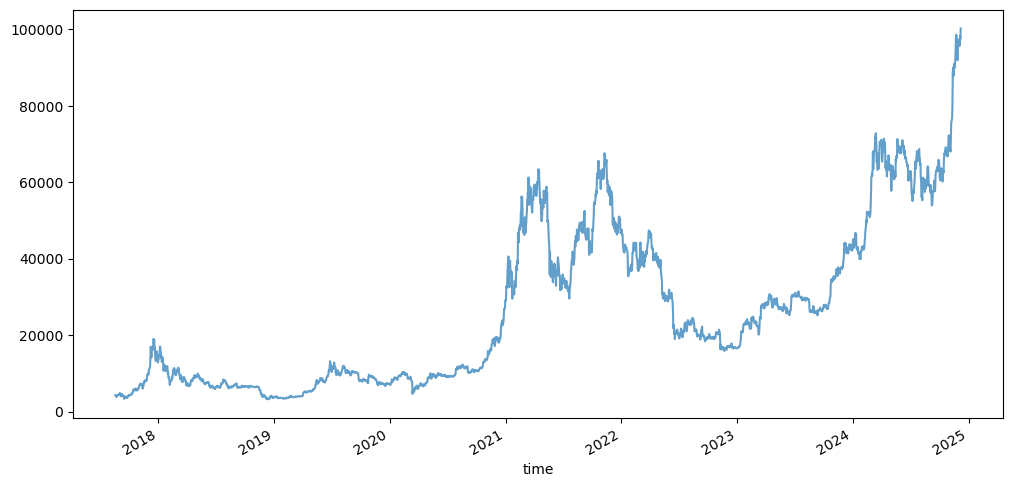

In [284]:
# verify the time ranges
print("--- Hourly Time Range ---")
print(btc_1h.index.min(), "to", btc_1h.index.max())

print("--- Daily Time Range ---")
print(btc_d.index.min(), "to", btc_d.index.max())

print("--- Combined Time Range ---")
print(btc_combined.index.min(), "to", btc_combined.index.max())

# Verify timestamp alignment in combined data
print("--- Sample Combined Timestamps ---")
print(btc_combined.index[:5])

# Plot Close Prices to verify alignment
plt.figure(figsize=(12, 6))
btc_combined["Close_1h"].plot(label="Hourly Close", alpha=0.7)


In [286]:
# normalize 
scaler = StandardScaler()
# Normalize numeric columns using log scaling
numeric_cols = btc_combined.select_dtypes(include=["float64", "int64"]).columns
btc_combined[numeric_cols] = btc_combined[numeric_cols].apply(
    lambda x: np.log1p(x.clip(lower=1e-9))
)


### 4: Feature Engineering
- Implement indicators
- Add new features and indicators here

In [289]:
# Add indicators for combined data
btc_combined["SMA_20"] = btc_combined["Close_1h"].rolling(window=20).mean()
btc_combined["SMA_50"] = btc_combined["Close_1h"].rolling(window=50).mean()
btc_combined["RSI"] = 100 - (100 / (1 + (btc_combined["Close_1h"].diff(1).clip(lower=0).rolling(14).mean() /
                                        -btc_combined["Close_1h"].diff(1).clip(upper=0).rolling(14).mean())))
btc_combined["MACD"] = (btc_combined["Close_1h"].ewm(span=12, adjust=False).mean() -
                         btc_combined["Close_1h"].ewm(span=26, adjust=False).mean())
btc_combined["Signal_Line"] = btc_combined["MACD"].ewm(span=9, adjust=False).mean()

In [291]:
# drop NaN's after adding indicators
btc_combined.dropna(inplace=True)

In [293]:
# verify it 
for name, df in zip(["Hourly", "Daily"], dataframes):
    print(f"--- Missing Values in {name} Data ---")
    print(df.isnull().sum(), "\n")

--- Missing Values in Hourly Data ---
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 

--- Missing Values in Daily Data ---
Date           0
Symbol         0
Open           0
High           0
Low            0
Close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64 



### ------------------ Model Selection and Implementation ------------------
- define a target
- choose a model: defaulting to random forest classification
- split data
- train model

In [296]:
# Define target variable
btc_combined["Target"] = np.where(btc_combined["Close_1h"].shift(-1) > btc_combined["Close_1h"], 1, 0)  # 1 = Up, 0 = Down

In [298]:
# Random Forest for classification (handles non-linear relationships and features effectively)
X = btc_combined.drop(columns=["Target", "Symbol_1h", "Symbol_d", "Date_1h", "Date_d"], errors="ignore")
y = btc_combined["Target"]


# Verify X contains only numeric data
print("--- Feature DataFrame Types ---")
print(X.dtypes)

--- Feature DataFrame Types ---
Open_1h           float64
High_1h           float64
Low_1h            float64
Close_1h          float64
Volume BTC_1h     float64
Volume USDT_1h    float64
tradecount_1h     float64
Open_d            float64
High_d            float64
Low_d             float64
Close_d           float64
Volume BTC_d      float64
Volume USDT_d     float64
tradecount_d      float64
SMA_20            float64
SMA_50            float64
RSI               float64
MACD              float64
Signal_Line       float64
dtype: object


In [300]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [302]:
# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### ------------------ Model Evaluation ------------------
- predictions and metrics

In [304]:
# Predictions and metrics
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4847328244274809
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.57      0.54       278
           1       0.44      0.39      0.42       246

    accuracy                           0.48       524
   macro avg       0.48      0.48      0.48       524
weighted avg       0.48      0.48      0.48       524

Confusion Matrix:
 [[158 120]
 [150  96]]


### --------------- Summarize Results --------------


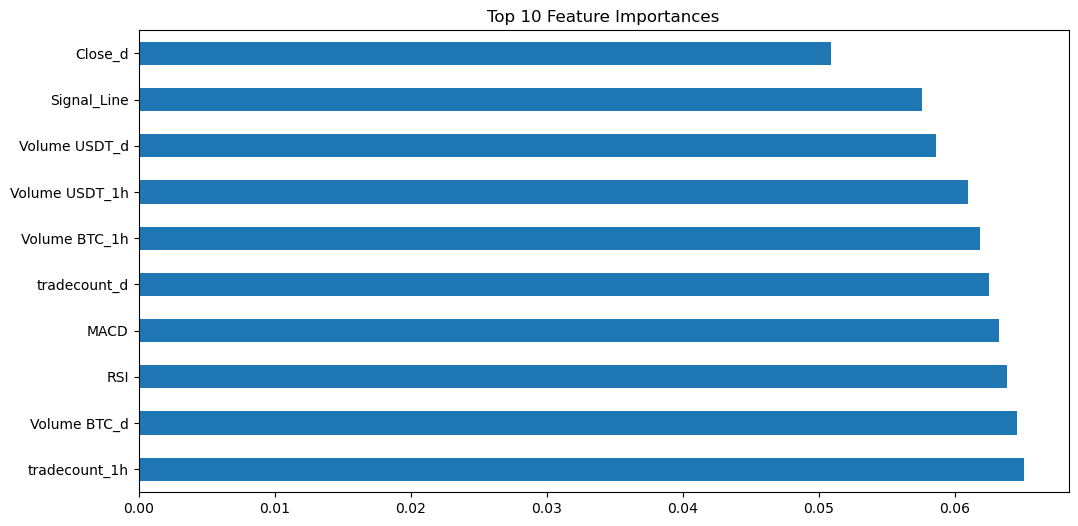

In [306]:
plt.figure(figsize=(12, 6))
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind="barh", title="Top 10 Feature Importances")
plt.show()

In [307]:
# Visualize predictions and actuals
y_test_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print("Sample Predictions vs Actuals:")
print(y_test_df.head())

Sample Predictions vs Actuals:
            Actual  Predicted
time                         
2017-09-27       1          0
2021-12-21       1          0
2018-09-24       1          1
2021-09-21       1          0
2019-06-23       0          1


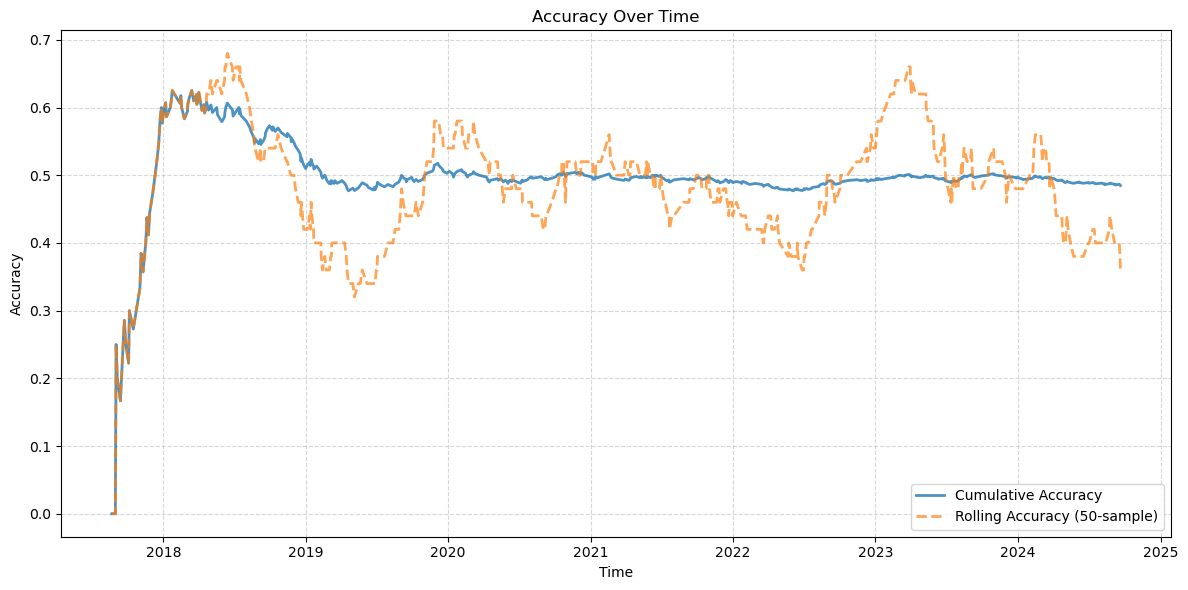

In [312]:
# Calculate Correct column
y_test_df["Correct"] = (y_test_df["Actual"] == y_test_df["Predicted"]).astype(int)

# Sort predictions and actuals by time for chronological order
y_test_df["Time"] = y_test.index
y_test_df.sort_values("Time", inplace=True)

# Calculate cumulative accuracy
y_test_df["Cumulative Accuracy"] = y_test_df["Correct"].expanding().mean()

# Add a rolling accuracy metric for smoother trends
rolling_window = 50
y_test_df["Rolling Accuracy"] = y_test_df["Correct"].rolling(window=rolling_window, min_periods=1).mean()

# Plot cumulative and rolling accuracy
plt.figure(figsize=(12, 6))
plt.plot(y_test_df["Time"], y_test_df["Cumulative Accuracy"], label="Cumulative Accuracy", alpha=0.8, linewidth=2)
plt.plot(y_test_df["Time"], y_test_df["Rolling Accuracy"], label=f"Rolling Accuracy ({rolling_window}-sample)", linestyle="--", alpha=0.7, linewidth=2)
plt.title("Accuracy Over Time")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


##### Accuracy over time chart
- Represents cumulative accuracy, the ration of correct predictions to the total number of predictions
    - rolling accuracy is optional
- Why it matters: trend insights showing sustained model performance, and highlights areas of stuggle
    - indicating market conditions underwhich the model performs poorly
- How to interpret the graph
    - upward slope, impoving accuracy as model consumes more data
    - flat line, consistent performance
    - down slope: deterioration of accuracy highlights areas to improve 

### ------------------ Back testing || In buildout phase ------------------
- Simulate Trades
- Track Performance
    - Cumulative Return
    - Daily returns
    - metrics: Total P/L, Percent win rate, maximum drawdown
- Visualize Performance
    - Equity curve showing cumulative returns over time
    - bar chart for daily returns 

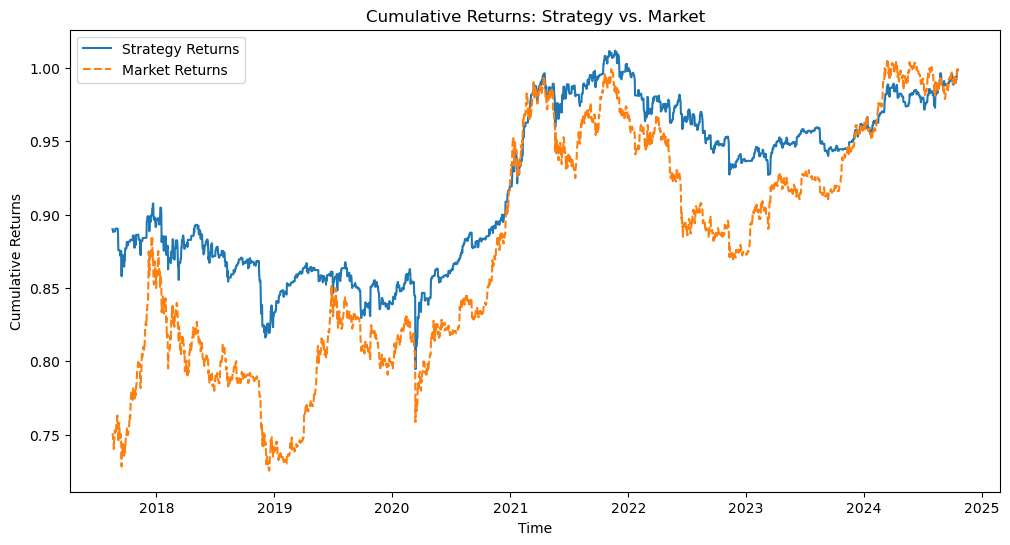

Total Return: -11.00%
Win Rate: 89.68%


In [316]:
# Backtesting Simulation
btc_combined["Prediction"] = model.predict(X)
btc_combined["Strategy_Return"] = btc_combined["Prediction"] * btc_combined["Close_1h"].pct_change()

# Calculate cumulative returns
btc_combined["Cumulative_Strategy_Return"] = (1 + btc_combined["Strategy_Return"]).cumprod()
btc_combined["Cumulative_Market_Return"] = (1 + btc_combined["Close_1h"].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(btc_combined["Cumulative_Strategy_Return"], label="Strategy Returns")
plt.plot(btc_combined["Cumulative_Market_Return"], label="Market Returns", linestyle="--")
plt.title("Cumulative Returns: Strategy vs. Market")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Key Metrics
total_return = btc_combined["Cumulative_Strategy_Return"].iloc[-1] - 1
winning_trades = (btc_combined["Prediction"] == btc_combined["Target"]).sum()
win_rate = winning_trades / len(btc_combined)
print(f"Total Return: {total_return:.2%}")
print(f"Win Rate: {win_rate:.2%}")


### Indicators

In [320]:
# Unified Feature Engineering in the Multi-Timeframe Setup

def add_features_to_combined(df):
    """
    Add engineered features to a multi-timeframe combined dataframe.
    This function assumes that `df` includes both hourly and daily data.
    """
    # Example columns: ['Close_1h', 'Close_d']

    # Moving Averages (Hourly and Daily)
    df['SMA_50_1h'] = df['Close_1h'].rolling(window=50).mean()
    df['SMA_200_1h'] = df['Close_1h'].rolling(window=200).mean()
    df['SMA_50_d'] = df['Close_d'].rolling(window=50).mean()
    df['SMA_200_d'] = df['Close_d'].rolling(window=200).mean()

    # Exponential Moving Averages (5 EMA and 13 EMA for Hourly and Daily)
    df['EMA_5_1h'] = df['Close_1h'].ewm(span=5, adjust=False).mean()
    df['EMA_13_1h'] = df['Close_1h'].ewm(span=13, adjust=False).mean()
    df['EMA_5_d'] = df['Close_d'].ewm(span=5, adjust=False).mean()
    df['EMA_13_d'] = df['Close_d'].ewm(span=13, adjust=False).mean()

    # Relative Strength Index (RSI)
    for timeframe in ['1h', 'd']:
        delta = df[f'Close_{timeframe}'].diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=14).mean()
        avg_loss = pd.Series(loss).rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df[f'RSI_{timeframe}'] = 100 - (100 / (1 + rs))

    # Price Change Percentage (Hourly and Daily)
    for timeframe in ['1h', 'd']:
        df[f'Price_Change_%_{timeframe}'] = (
            (df[f'Close_{timeframe}'] - df[f'Open_{timeframe}']) / df[f'Open_{timeframe}'] * 100
        )

    # Bollinger Bands (Hourly and Daily)
    for timeframe in ['1h', 'd']:
        df[f'BB_Middle_{timeframe}'] = df[f'Close_{timeframe}'].rolling(window=20).mean()
        df[f'BB_Upper_{timeframe}'] = (
            df[f'BB_Middle_{timeframe}'] + 2 * df[f'Close_{timeframe}'].rolling(window=20).std()
        )
        df[f'BB_Lower_{timeframe}'] = (
            df[f'BB_Middle_{timeframe}'] - 2 * df[f'Close_{timeframe}'].rolling(window=20).std()
        )

    # Average True Range (ATR)
    for timeframe in ['1h', 'd']:
        high_low = df[f'High_{timeframe}'] - df[f'Low_{timeframe}']
        high_close = abs(df[f'High_{timeframe}'] - df[f'Close_{timeframe}'].shift())
        low_close = abs(df[f'Low_{timeframe}'] - df[f'Close_{timeframe}'].shift())
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        df[f'ATR_{timeframe}'] = tr.rolling(window=14).mean()

    # Fibonacci Retracement Levels (based on High and Low in a rolling window)
    for timeframe in ['1h', 'd']:
        rolling_max = df[f'High_{timeframe}'].rolling(window=14).max()
        rolling_min = df[f'Low_{timeframe}'].rolling(window=14).min()
        df[f'Fib_0.236_{timeframe}'] = rolling_max - (rolling_max - rolling_min) * 0.236
        df[f'Fib_0.382_{timeframe}'] = rolling_max - (rolling_max - rolling_min) * 0.382
        df[f'Fib_0.5_{timeframe}'] = rolling_max - (rolling_max - rolling_min) * 0.5
        df[f'Fib_0.618_{timeframe}'] = rolling_max - (rolling_max - rolling_min) * 0.618
        df[f'Fib_0.786_{timeframe}'] = rolling_max - (rolling_max - rolling_min) * 0.786
        df[f'Fib_1.0_{timeframe}'] = rolling_max
        df[f'Fib_1.618_{timeframe}'] = rolling_max + (rolling_max - rolling_min) * 0.618
        df[f'Fib_2.0_{timeframe}'] = rolling_max + (rolling_max - rolling_min) * 1.0

    return df

In [348]:
def generate_signals(df):
    """
    Generate trading signals based on the engineered features.
    """
    for timeframe in ['1h', 'd']:
        # Moving Average Crossover Signals
        df[f'Signal_EMA_Crossover_{timeframe}'] = 0
        df.loc[df[f'EMA_5_{timeframe}'] > df[f'EMA_13_{timeframe}'], f'Signal_EMA_Crossover_{timeframe}'] = 1  # Bullish
        df.loc[df[f'EMA_5_{timeframe}'] < df[f'EMA_13_{timeframe}'], f'Signal_EMA_Crossover_{timeframe}'] = -1  # Bearish

    for timeframe in ['1h', 'd']:
        delta = df[f'Close_{timeframe}'].diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=14, min_periods=1).mean()
        avg_loss = pd.Series(loss).rolling(window=14, min_periods=1).mean()
        rs = avg_gain / avg_loss
        df[f'RSI_{timeframe}'] = 100 - (100 / (1 + rs))


        # Bollinger Band Signals
        df[f'Signal_Bollinger_{timeframe}'] = 0
        df.loc[df[f'Close_{timeframe}'] <= df[f'BB_Lower_{timeframe}'], f'Signal_Bollinger_{timeframe}'] = 1  # Buy
        df.loc[df[f'Close_{timeframe}'] >= df[f'BB_Upper_{timeframe}'], f'Signal_Bollinger_{timeframe}'] = -1  # Sell

        # Fibonacci Retracement Signals
        df[f'Signal_Fib_{timeframe}'] = 0
        df.loc[(df[f'Close_{timeframe}'] <= df[f'Fib_0.618_{timeframe}']) & \
               (df[f'Close_{timeframe}'] >= df[f'Fib_0.5_{timeframe}']), f'Signal_Fib_{timeframe}'] = 1  # Within Golden Zone
        df.loc[df[f'Close_{timeframe}'] >= df[f'Fib_1.0_{timeframe}'], f'Signal_Fib_{timeframe}'] = -1  # Near Top

        # Combined Signal (Hourly and Daily)
    df['Signal_Combined'] = (
        0.6 * df['Signal_EMA_Crossover_d'] +
        0.4 * df['Signal_EMA_Crossover_1h'] +
        0.2 * (df['Signal_RSI_1h'] + df['Signal_RSI_d']) +
        0.2 * (df['Signal_Bollinger_1h'] + df['Signal_Bollinger_d'])
    ).apply(np.sign)

    return df

In [350]:
# Example usage
btc_combined = add_features_to_combined(btc_combined)
btc_combined = generate_signals(btc_combined)

In [352]:
# signal summary table
signal_columns = [col for col in btc_combined.columns if 'Signal' in col]
print(btc_combined[signal_columns].describe())

       Signal_Line  Signal_EMA_Crossover_1h  Signal_RSI_1h  \
count  2617.000000              2617.000000         2617.0   
mean     -0.007802                -0.090944            0.0   
std       0.044360                 0.995854            0.0   
min      -0.157404                -1.000000            0.0   
25%      -0.033648                -1.000000            0.0   
50%      -0.005926                -1.000000            0.0   
75%       0.018014                 1.000000            0.0   
max       0.123995                 1.000000            0.0   

       Signal_Bollinger_1h  Signal_Fib_1h  Signal_EMA_Crossover_d  \
count          2617.000000    2617.000000             2617.000000   
mean              0.011464      -0.001146               -0.094001   
std               0.344050       0.033845                0.995570   
min              -1.000000      -1.000000               -1.000000   
25%               0.000000       0.000000               -1.000000   
50%               0.000000 

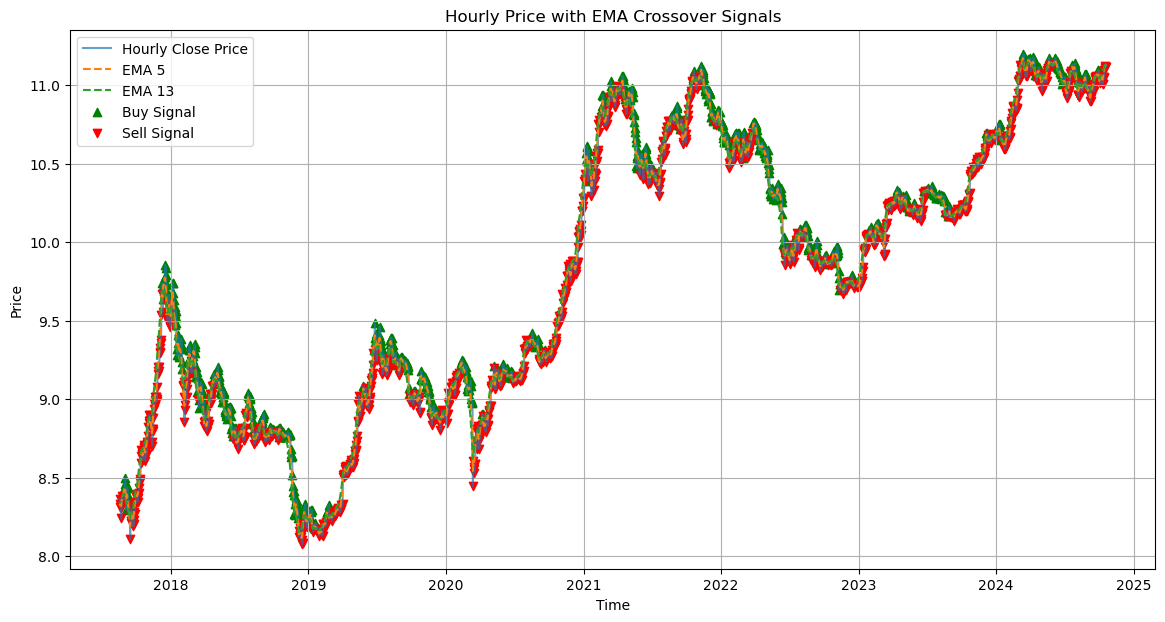

In [354]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(btc_combined.index, btc_combined['Close_1h'], label="Hourly Close Price", alpha=0.7)
plt.plot(btc_combined.index, btc_combined['EMA_5_1h'], label="EMA 5", linestyle='--')
plt.plot(btc_combined.index, btc_combined['EMA_13_1h'], label="EMA 13", linestyle='--')

buy_signals = btc_combined[btc_combined['Signal_EMA_Crossover_1h'] == 1]
sell_signals = btc_combined[btc_combined['Signal_EMA_Crossover_1h'] == -1]

plt.scatter(buy_signals.index, buy_signals['Close_1h'], label="Buy Signal", marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Close_1h'], label="Sell Signal", marker='v', color='red')

plt.title("Hourly Price with EMA Crossover Signals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [356]:
rsi_signals = btc_combined[(btc_combined['RSI_1h'] < 30) | (btc_combined['RSI_1h'] > 70)]
print(rsi_signals[['RSI_1h', 'Signal_RSI_1h']].head())
bollinger_signals = btc_combined[
    (btc_combined['Close_1h'] <= btc_combined['BB_Lower_1h']) |
    (btc_combined['Close_1h'] >= btc_combined['BB_Upper_1h'])
]
print(bollinger_signals[['Close_1h', 'BB_Lower_1h', 'BB_Upper_1h', 'Signal_Bollinger_1h']].head())

print(btc_combined[['Signal_EMA_Crossover_1h', 'Signal_EMA_Crossover_d', 'Signal_Combined']].head())

Empty DataFrame
Columns: [RSI_1h, Signal_RSI_1h]
Index: []
             Close_1h  BB_Lower_1h  BB_Upper_1h  Signal_Bollinger_1h
time                                                                
2024-09-17  10.961816    10.980363    11.112885                    1
2024-08-27  11.046483    10.894012    11.041576                   -1
2024-08-26  11.068387    10.885797    11.056374                   -1
2024-08-25  11.069400    10.879406    11.068805                   -1
2024-08-08  10.920546    10.932284    11.082002                    1
            Signal_EMA_Crossover_1h  Signal_EMA_Crossover_d  Signal_Combined
time                                                                        
2024-10-19                        0                       0              0.0
2024-10-18                       -1                       1              1.0
2024-10-17                       -1                      -1             -1.0
2024-10-16                       -1                      -1             -

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: RSI_1h, dtype: float64


<Axes: >

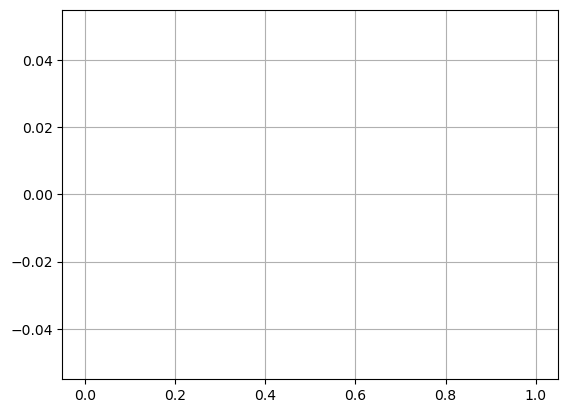

In [361]:
print(btc_combined['RSI_1h'].describe())
btc_combined['RSI_1h'].hist(bins=50)


### Clean Data function

In [378]:
def clean_data(df):
    """
    Clean the dataframe after feature and signal generation.
    Removes NaN values and fills gaps where necessary.
    """
    # Fill missing values for rolling and EMA operations
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    required_columns = ['Signal_Combined']
    df.dropna(subset=required_columns, inplace=True)


    return df


In [380]:
btc_combined = clean_data(btc_combined)

print(btc_combined.isnull().sum())
print(btc_combined.describe())


Date_1h                   0
Symbol_1h                 0
Open_1h                   0
High_1h                   0
Low_1h                    0
                         ..
Signal_EMA_Crossover_d    0
Signal_RSI_d              0
Signal_Bollinger_d        0
Signal_Fib_d              0
Signal_Combined           0
Length: 73, dtype: int64
       Open_1h  High_1h  Low_1h  Close_1h  Volume BTC_1h  Volume USDT_1h  \
count      0.0      0.0     0.0       0.0            0.0             0.0   
mean       NaN      NaN     NaN       NaN            NaN             NaN   
std        NaN      NaN     NaN       NaN            NaN             NaN   
min        NaN      NaN     NaN       NaN            NaN             NaN   
25%        NaN      NaN     NaN       NaN            NaN             NaN   
50%        NaN      NaN     NaN       NaN            NaN             NaN   
75%        NaN      NaN     NaN       NaN            NaN             NaN   
max        NaN      NaN     NaN       NaN            NaN   

In [382]:
dropped_rows = btc_combined[pd.isnull(btc_combined[['RSI_1h', 'Signal_RSI_1h']]).any(axis=1)]
print(dropped_rows)


Empty DataFrame
Columns: [Date_1h, Symbol_1h, Open_1h, High_1h, Low_1h, Close_1h, Volume BTC_1h, Volume USDT_1h, tradecount_1h, Date_d, Symbol_d, Open_d, High_d, Low_d, Close_d, Volume BTC_d, Volume USDT_d, tradecount_d, SMA_20, SMA_50, RSI, MACD, Signal_Line, Target, Prediction, Strategy_Return, Cumulative_Strategy_Return, Cumulative_Market_Return, SMA_50_1h, SMA_200_1h, SMA_50_d, SMA_200_d, EMA_5_1h, EMA_13_1h, EMA_5_d, EMA_13_d, RSI_1h, RSI_d, Price_Change_%_1h, Price_Change_%_d, BB_Middle_1h, BB_Upper_1h, BB_Lower_1h, BB_Middle_d, BB_Upper_d, BB_Lower_d, ATR_1h, ATR_d, Fib_0.236_1h, Fib_0.382_1h, Fib_0.5_1h, Fib_0.618_1h, Fib_0.786_1h, Fib_1.0_1h, Fib_1.618_1h, Fib_2.0_1h, Fib_0.236_d, Fib_0.382_d, Fib_0.5_d, Fib_0.618_d, Fib_0.786_d, Fib_1.0_d, Fib_1.618_d, Fib_2.0_d, Signal_EMA_Crossover_1h, Signal_RSI_1h, Signal_Bollinger_1h, Signal_Fib_1h, Signal_EMA_Crossover_d, Signal_RSI_d, Signal_Bollinger_d, Signal_Fib_d, Signal_Combined]
Index: []

[0 rows x 73 columns]
